# Import Libraries

In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats.mstats import winsorize
from scipy.interpolate import griddata

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, learning_curve
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense, Dropout, MaxPool1D, Flatten
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import mean_absolute_error

import pickle as pkl

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Functions

In [3]:
## Predicting validation data
def pred_val(df, columns, sc, model):

    scaled_df = sc.transform(df)
    
    scaled_df = pd.DataFrame(scaled_df, 
                             columns=df.columns)
    
    scaled_df = scaled_df[columns]

    y_pred = model.predict(scaled_df)

    return y_pred

## Evaluate the final model
def eval_model(y, y_pred, title):
    
    # mse = mean_squared_error(y, y_pred)
    # medae = median_absolute_error(y, y_pred)
    # rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    # r_squared = r2_score(y, y_pred)

    print(f'{title}')
    # print(f'Median Absolute Error: {np.round(medae, 2)}')
    # print(f'Root Mean Squared Error: {np.round(rmse, 2)}')
    print(f'Mean Absolute Error: {np.round(mae, 2)}')
    # print(f'R-squared Error: {np.round(r_squared, 2)}')

## Plotting Learning curves
def plot_learing_curve(model, X, y, cv, model_title):

    train_sizes = [50, 100, 200, 400, 760]

    train_sizes, train_scores, validation_scores = learning_curve(model, X, y, 
                                                                  train_sizes=train_sizes, 
                                                                  cv=cv, 
                                                                  scoring='neg_mean_squared_error', 
                                                                  shuffle=True)

    train_scores_mean = -train_scores.mean(axis=1)
    validation_scores_mean = -validation_scores.mean(axis=1)

    plt.style.use('seaborn')
    plt.plot(train_sizes, 
             train_scores_mean, 
             label = 'Training error')
    plt.plot(train_sizes, 
             validation_scores_mean, 
             label = 'Validation error')
    plt.ylabel('MSE', 
               fontsize = 14)
    plt.xlabel('Training set size', 
               fontsize = 14)
    plt.title(f'Learning curves for a {model_title} model', 
              fontsize = 18, 
              y = 1.03)
    plt.legend()
    plt.ylim(0,40)

## Learning rate scheduler
def step_decay(initial_lr, epoch):
    drop = 0.5
    epochs_drop = 10.0
    lr = initial_lr * (drop ** ((1 + epoch) // epochs_drop))
    return lr

## Train vs Val loss
def metrics_graph(model, num_epoch):
    
    r_ep = range(num_epoch)
    train_loss = model.history['loss']
    validation_loss = model.history['val_loss']

    plt.figure(figsize=(15,7))
    
    plt.subplot(1, 2, 1)
    plt.title('Train vs Validation')
    plt.plot(r_ep, train_loss)
    plt.plot(r_ep, validation_loss)
    plt.legend(['train_loss', 'val_loss'])
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')

# Load Data

In [4]:
curr_dir = (os.getcwd()).replace('\\', '/')
data_path = (os.path.join(curr_dir, 'Data')).replace('\\', '/')

In [5]:
str_sed_data = pd.read_csv(data_path + '/Kodangal dataset/clean_Kodangal_gcM.csv')

In [6]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,toposheet,sio2,al2o3,fe2o3,tio2,...,hf,ta,w,u,in_,f,te,tl,hg,cd
0,274643,276298,56G04/014/SS/18-19,77.25,17.00904,56G04,44.750,9.414,3.312,0.543,...,5.746369,0.862203,0.991997,1.811020,0.052741,322.0,0.101815,0.293517,17.0,50.0
1,274657,276312,56G04/028/SS/18-19,77.25,17.02711,56G04,45.129,9.853,3.748,0.580,...,7.857656,0.958655,0.943758,2.203597,0.048799,336.0,0.072979,0.300787,8.0,50.0
2,274671,276326,56G04/042/SS/18-19,77.25,17.04518,56G04,58.283,12.534,7.768,1.321,...,8.728652,1.428838,1.682294,2.711943,0.126064,205.0,0.121959,0.481961,12.0,50.0
3,274685,276340,56G04/056/SS/18-19,77.25,17.06325,56G04,61.180,11.670,8.340,1.420,...,9.365000,1.542800,1.803219,2.982200,0.084033,230.0,0.071592,0.427797,10.0,50.0
4,274699,276354,56G04/070/SS/18-19,77.25,17.08132,56G04,60.300,11.470,8.270,1.430,...,10.693400,1.467300,1.451395,3.249200,0.083470,300.0,0.067475,0.447018,6.0,50.0


# EDA

In [7]:
str_elem = []

for col in list(str_sed_data.columns):
    if col not in ['gid', 
                   'objectid', 
                   'sampleno', 
                   'longitude', 
                   'latitude', 
                   'toposheet']:
        str_elem.append(col)

In [8]:
len(str_elem)

62

In [9]:
elem_df = str_sed_data[str_elem]
elem_df.head()

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,hf,ta,w,u,in_,f,te,tl,hg,cd
0,44.750,9.414,3.312,0.543,14.668,1.573,0.073,0.152,1.258,0.129,...,5.746369,0.862203,0.991997,1.811020,0.052741,322.0,0.101815,0.293517,17.0,50.0
1,45.129,9.853,3.748,0.580,14.042,1.480,0.109,0.167,1.207,0.080,...,7.857656,0.958655,0.943758,2.203597,0.048799,336.0,0.072979,0.300787,8.0,50.0
2,58.283,12.534,7.768,1.321,2.910,1.912,0.192,0.050,0.800,0.061,...,8.728652,1.428838,1.682294,2.711943,0.126064,205.0,0.121959,0.481961,12.0,50.0
3,61.180,11.670,8.340,1.420,2.430,1.710,0.180,0.250,0.660,0.080,...,9.365000,1.542800,1.803219,2.982200,0.084033,230.0,0.071592,0.427797,10.0,50.0
4,60.300,11.470,8.270,1.430,1.990,1.610,0.170,0.230,0.580,0.060,...,10.693400,1.467300,1.451395,3.249200,0.083470,300.0,0.067475,0.447018,6.0,50.0


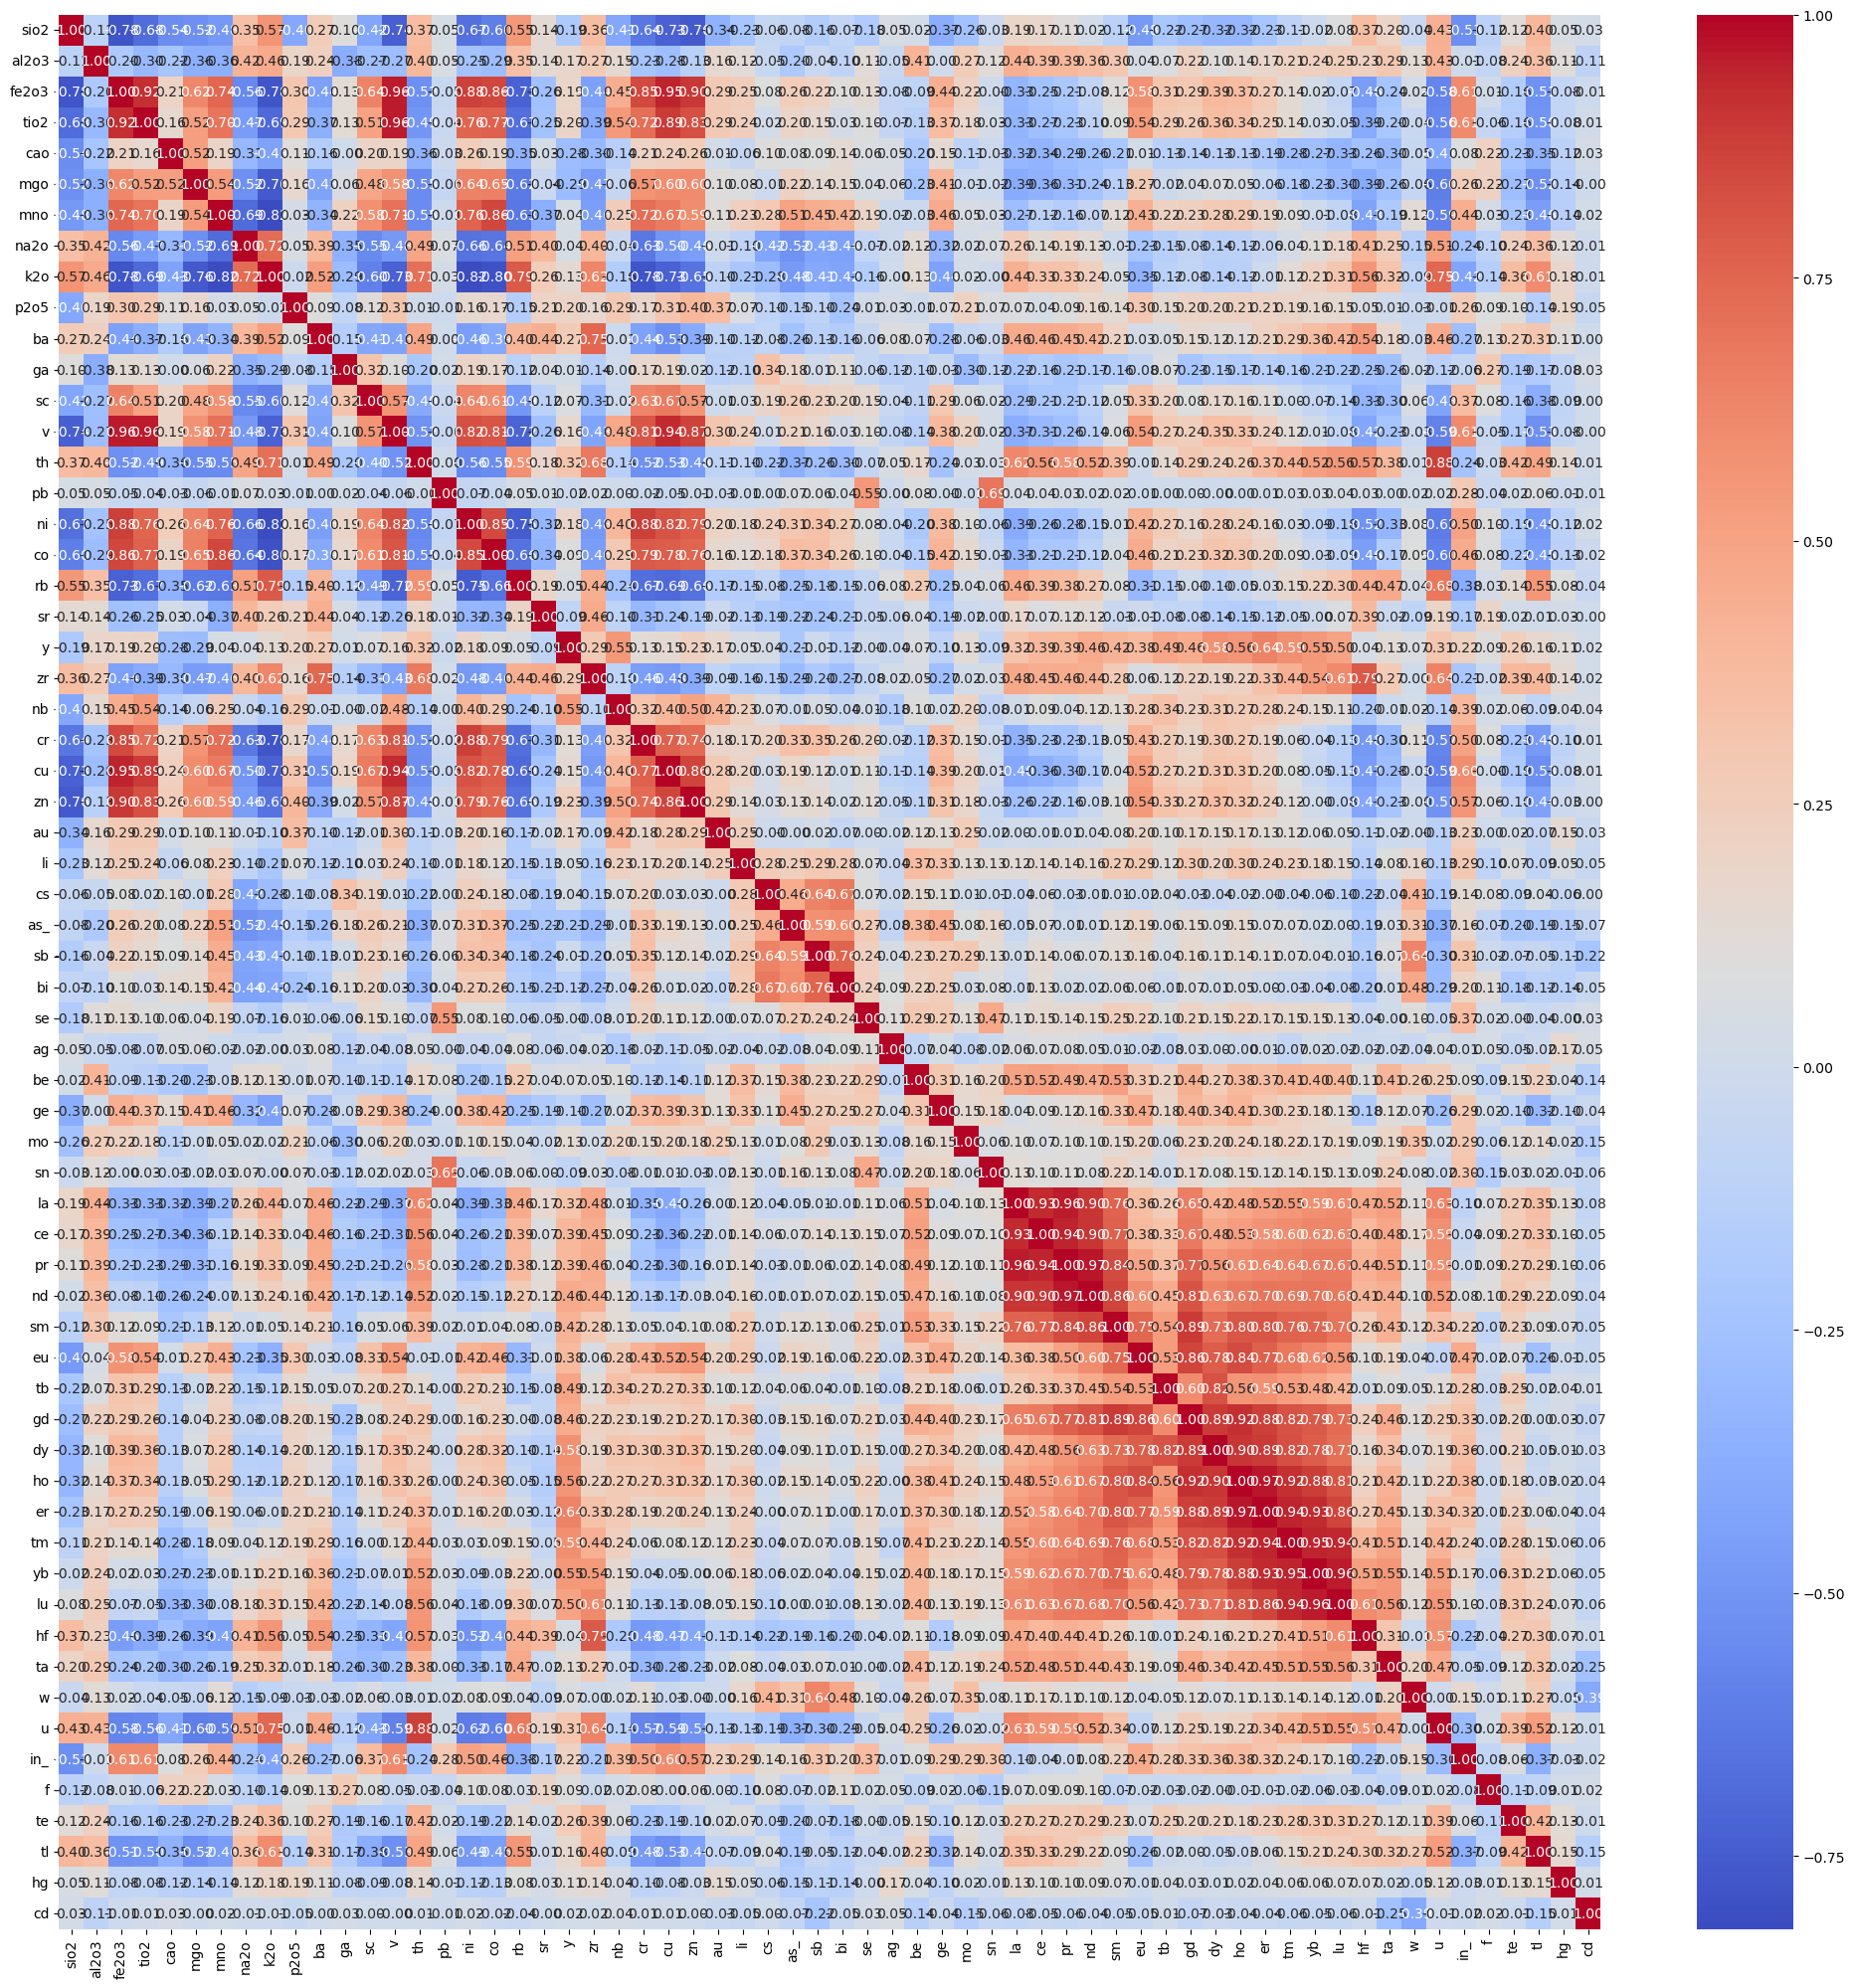

In [10]:
plt.figure(figsize=(25,25))
sns.heatmap(elem_df.corr(), 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm')
plt.show()

### Histogram plots

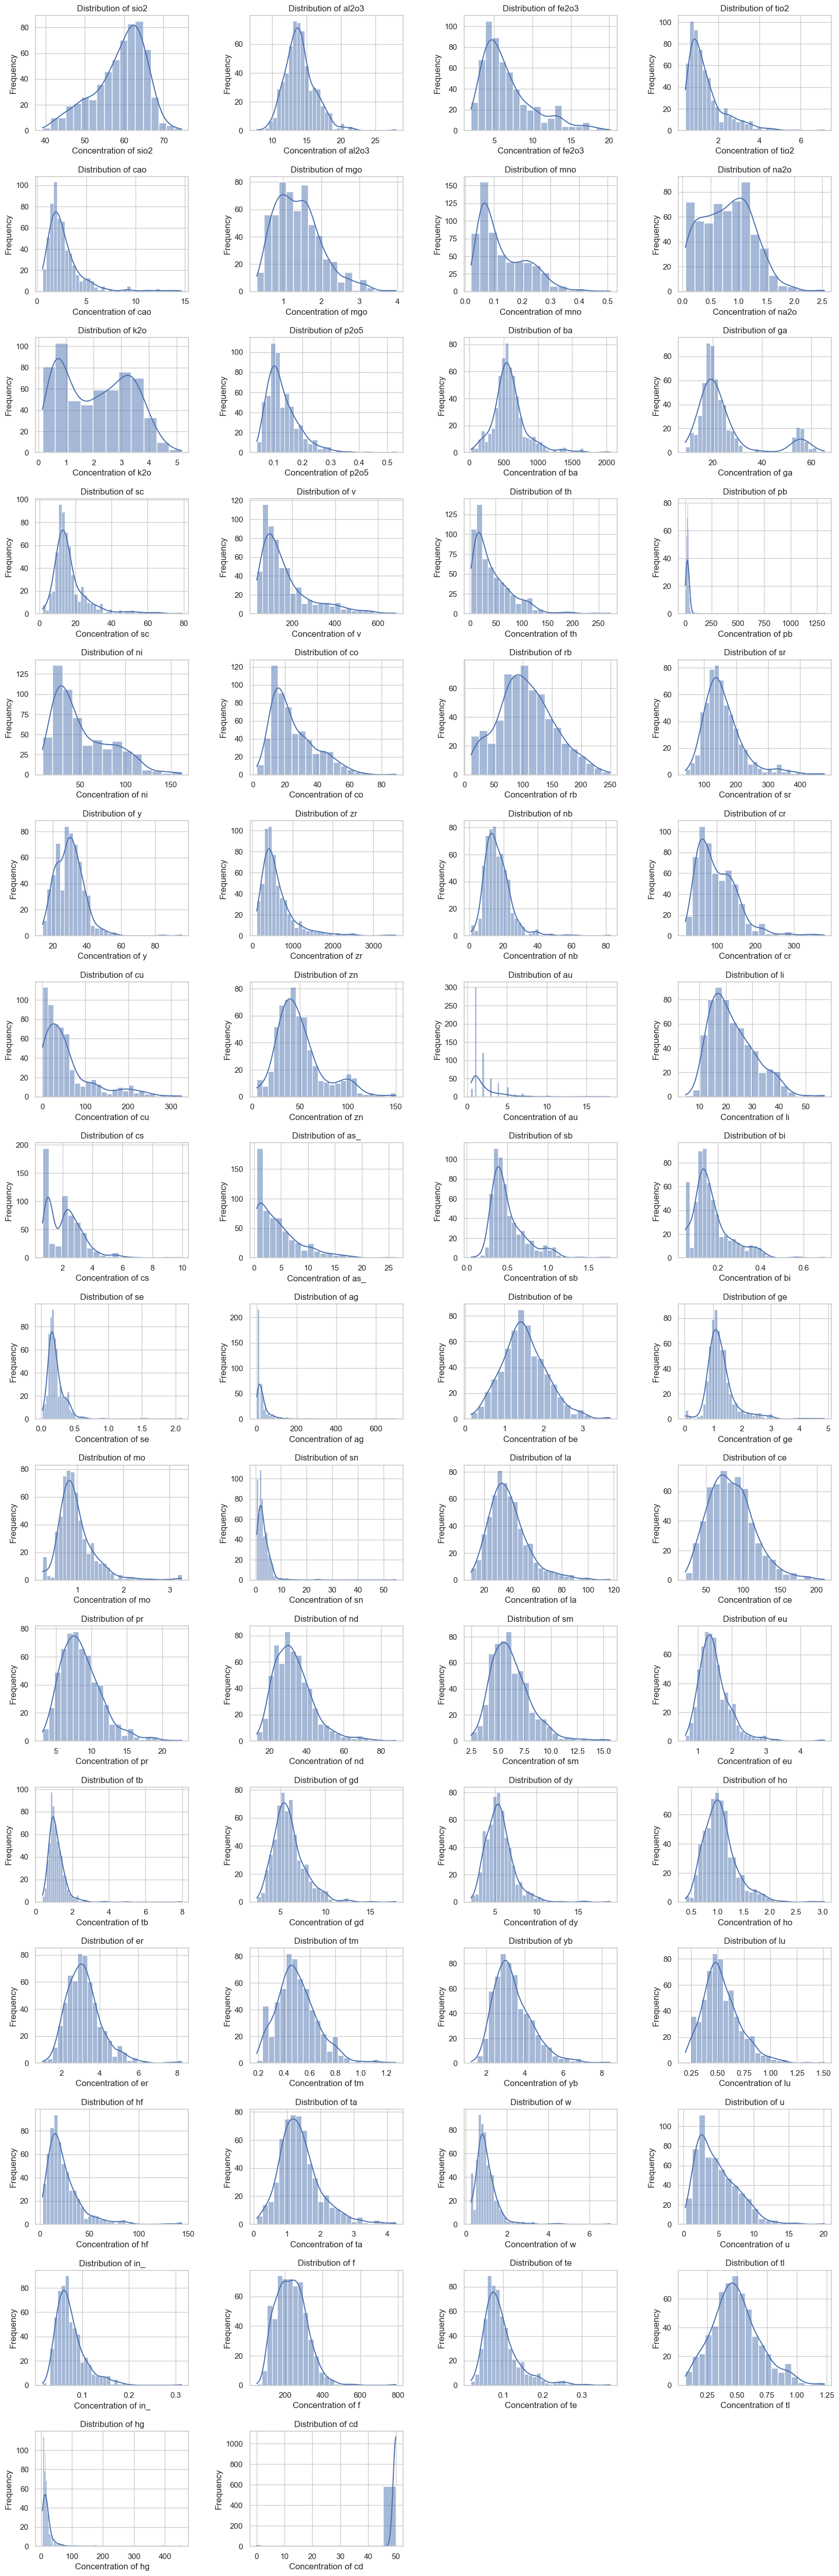

In [11]:
num_elem = len(str_elem)
num_cols = 4
num_rows = (num_elem + num_cols - 1)//num_cols 

sns.set(style='whitegrid')

fig, axes = plt.subplots(num_rows, 
                         num_cols, 
                         figsize=(num_cols*5, num_rows*4))

fig.subplots_adjust(hspace=0.4, 
                    wspace=0.4)

for i, elem in enumerate(str_elem):

    ax = axes[i // num_cols, i % num_cols]  # Determine the position in the grid
    sns.histplot(elem_df[elem], 
                 kde=True, 
                 ax=ax)
    ax.set_title(f'Distribution of {elem}')
    ax.set_xlabel(f'Concentration of {elem}')
    ax.set_ylabel('Frequency')

# If there are any empty subplots in the grid, hide them
for j in range(i + 1, num_rows * num_cols):
    axes[j // num_cols, j % num_cols].axis('off')

plt.show()

## Boxplots

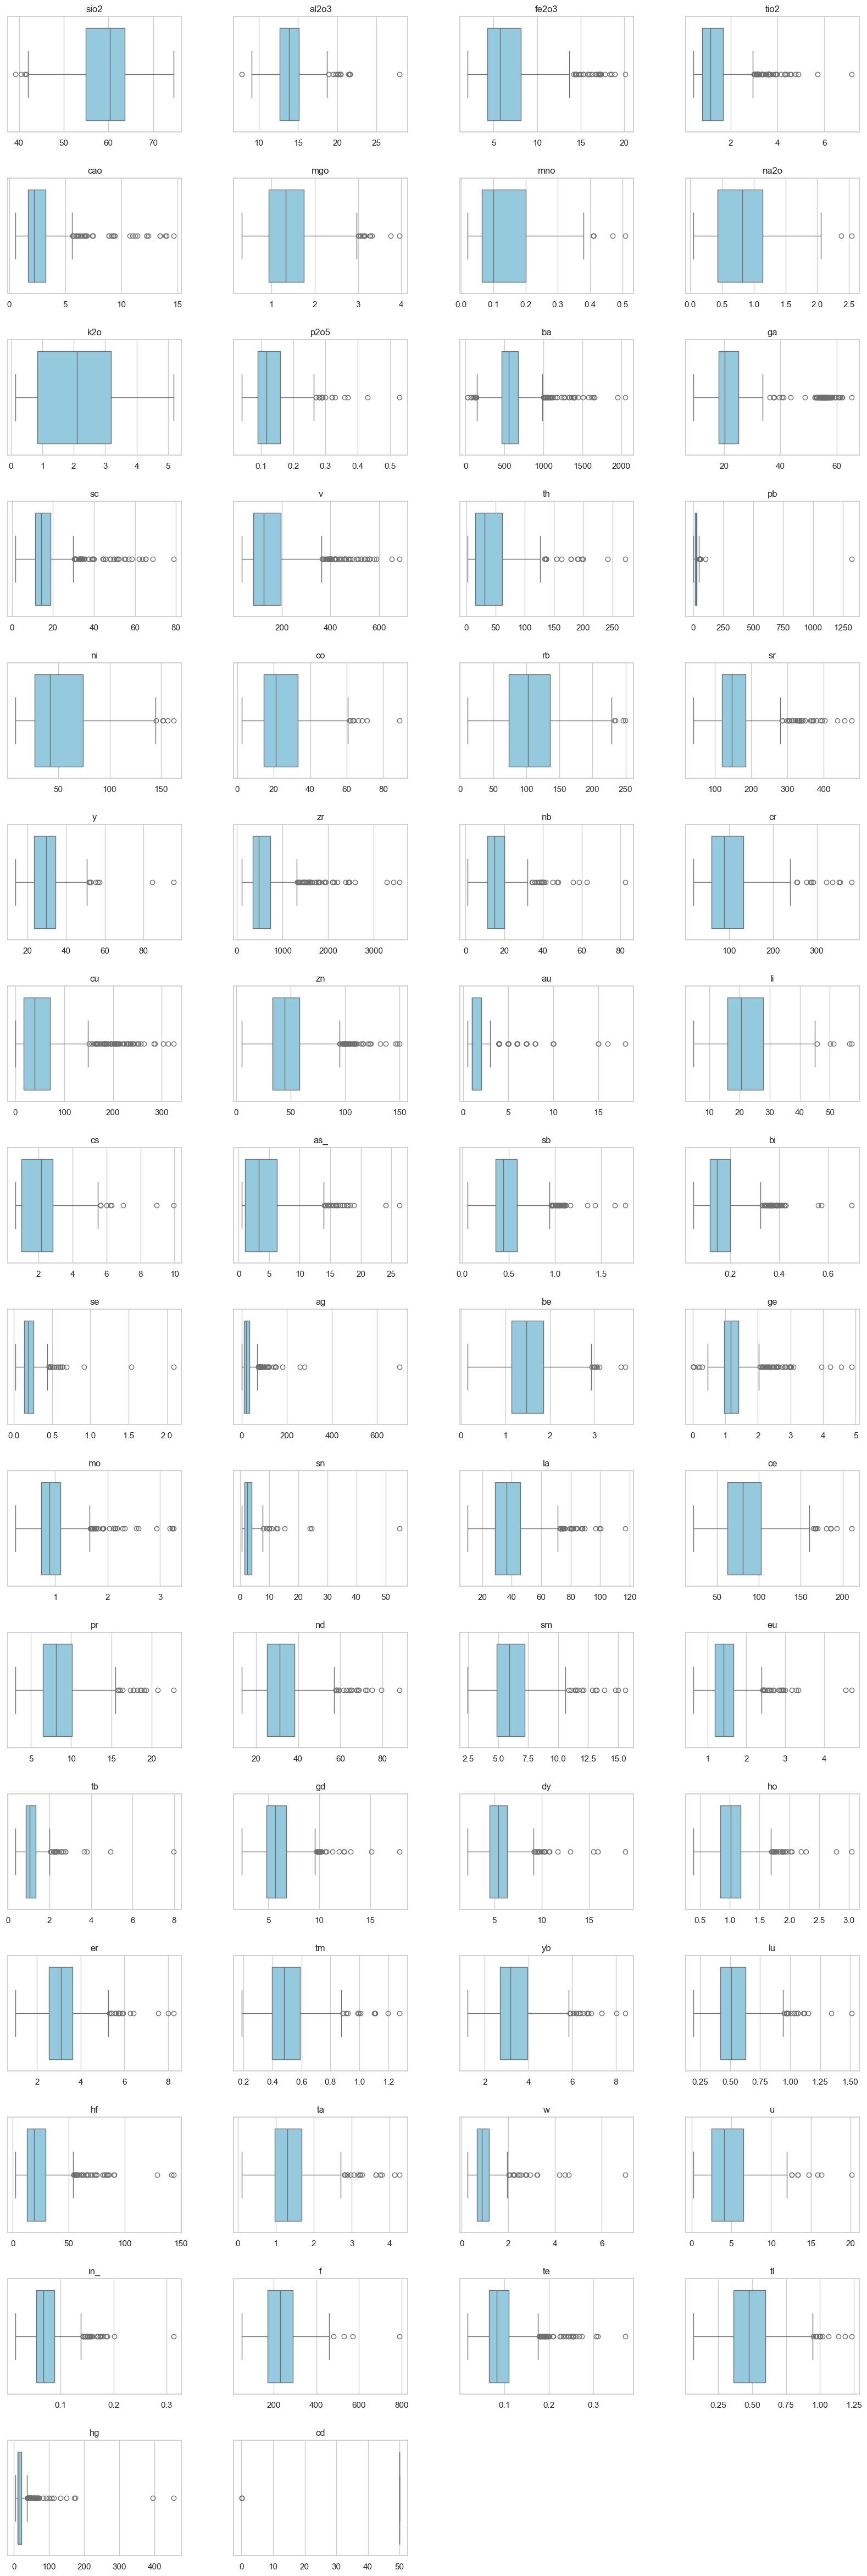

In [12]:
n_elem = len(str_elem)

fig, axes = plt.subplots(nrows=(n_elem+4-1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(str_elem, axes.flatten())):
    sns.boxplot(x=elem_df[str_elem][elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+4-1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

### Drop elements based on certain condition

- Elements having concentration values less than 1

In [10]:
drop_elem = ['mno', 'p2o5', 'sb', 'bi', 'se', 'in_', 'te', 'tl']

In [11]:
elem_df.drop(drop_elem, axis=1, inplace=True)

- Elements having same almost same values at each sample

In [12]:
elem_df.drop(['cd'], axis=1, inplace=True)

## Handling outliers

In [13]:
def handle_outl(df):

    cols = list(df.columns)
    
    for elem in cols:
        
        Q1 = df[elem].quantile(0.25)
        Q3 = df[elem].quantile(0.75)
        IQR = Q3 - Q1
        lwr_bnd = Q1 - (1.5 * IQR)
        upr_bnd = Q3 + (1.5 * IQR)

        quantiles = {
            87 : df[elem].quantile(0.87), 
            90 : df[elem].quantile(0.90),
            92.5 : df[elem].quantile(0.925),
            95 : df[elem].quantile(0.95),
            97.5 : df[elem].quantile(0.975),
            99 : df[elem].quantile(0.99)
        }
        
        min_diff = float('inf')
        nearest_key = None
        for key, val in quantiles.items():
        
            if val >= upr_bnd:
                diff = val - upr_bnd
                if diff < min_diff:
                    min_diff = diff
                    nearest_key = key
        
        if nearest_key is None:
            df[elem] = df[elem].apply(lambda x: upr_bnd if x > upr_bnd else x)
            continue
        
        nearest_key = (100 - nearest_key) / 100
        nearest_key = np.round(nearest_key, 3)
        df[elem] = winsorize(df[elem], limits=(0.05, nearest_key))

    return df

In [14]:
elem_outl_df = handle_outl(elem_df)

### After handling outliers

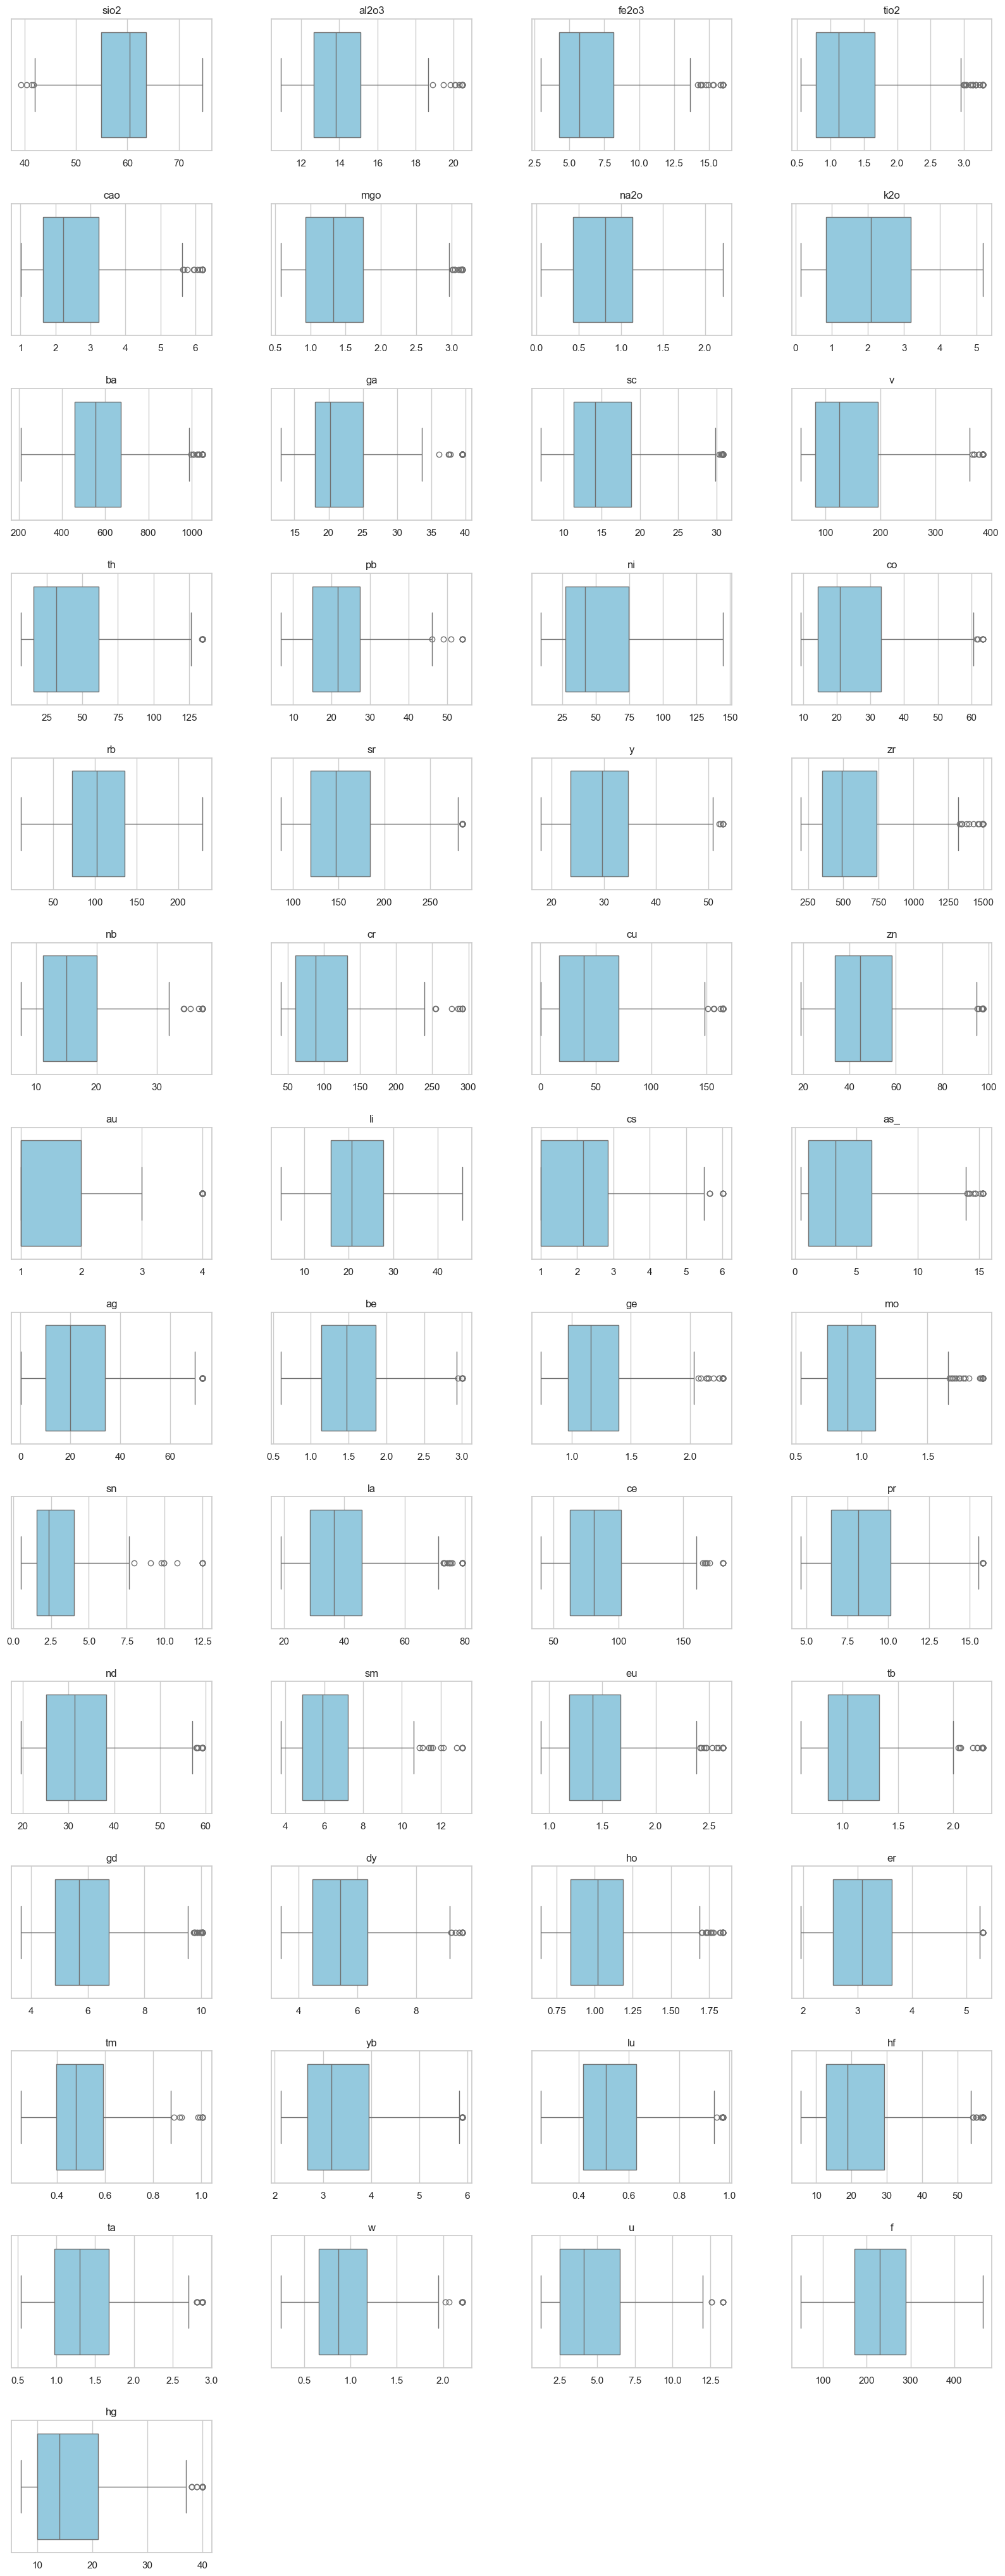

In [18]:
n_elem = len(elem_outl_df.columns)

fig, axes = plt.subplots(nrows=(n_elem+4-1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(elem_outl_df.columns, axes.flatten())):
    sns.boxplot(x=elem_outl_df[elem_outl_df.columns][elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+4-1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

# Normalize

In [15]:
train_df = elem_outl_df.copy()
target = elem_outl_df['cu']
train_df.drop(['cu'], axis=1, inplace=True)

In [16]:
train_df.shape

(588, 52)

In [17]:
# sc = StandardScaler()

# norm_data = sc.fit_transform(train_df)

sc = RobustScaler()

norm_data = sc.fit_transform(train_df)

# min_max = MinMaxScaler()
# norm_data = min_max.fit_transform(train_df)

# train_df_norm = pd.DataFrame(norm_data, 
#                             index=train_df.index, 
#                             columns=train_df.columns)

In [18]:
n_samples = len(train_df)
n_features = len(train_df.columns)
train_df = norm_data.reshape((n_samples, n_features, 1))
train_df.shape

(588, 52, 1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train_df, 
                                                    target, 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    shuffle=True)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.1, 
                                                  random_state=42,
                                                  shuffle=True)

# Model Training

## CNN

In [21]:
def cnn_model(n_features, learning_rate):
    
    model = Sequential()

    model.add(Conv1D(32, kernel_size=3, padding='same', input_shape=(n_features, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    model.add(Dropout(0.3))

    model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    model.add(Dropout(0.3))

    model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    model.add(Dropout(0.5))

    model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    model.add(Dropout(0.5))

    model.add(Conv1D(512, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    model.add(Dropout(0.5))

    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    # model.add(Dense(512, activation='relu'))
    model.add(Dense(1))

    opt = Adam(learning_rate)
    model.compile(optimizer=opt, loss='mae')

    return model

In [22]:
lr = 0.001

# lr_schdlr = LearningRateScheduler(step_decay)

lr_schdlr = ExponentialDecay(initial_learning_rate=lr, 
                             decay_steps=100, 
                             decay_rate=0.96, 
                             staircase=True)

# lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
#                               factor=0.1, 
#                               patience=5, 
#                               min_lr=0.001)

# erly_stp = EarlyStopping(monitor='val_loss', 
#                          verbose=1, 
#                          patience=20, 
#                          mode='min')

In [23]:
model = cnn_model(n_features, lr_schdlr)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 52, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 52, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 26, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 26, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 26, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 13, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 13, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 6, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 3, 512)              │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 3, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 1, 512)              │              

 Total params: 587,425 (2.24 MB)

 Trainable params: 585,441 (2.23 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [24]:
cnnmodel = model.fit(X_train, y_train, 
                     epochs=100, batch_size=32, 
                     validation_data=(X_val, y_val))

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 51.8886 - val_loss: 68.4708
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 29.8091 - val_loss: 67.8142
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 23.0253 - val_loss: 66.9773
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 20.5809 - val_loss: 63.7596
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 21.5024 - val_loss: 63.7343
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 18.8116 - val_loss: 61.3909
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 18.2675 - val_loss: 56.3498
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 19.1694 - val_loss: 55.6147
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 19.2044 - val_loss: 55.6818
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 18.0407 - val_loss: 47.9508
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 17.0212 - val_loss: 46.7815
Epoch 12/100
15/15 ━━━━━━━━━━

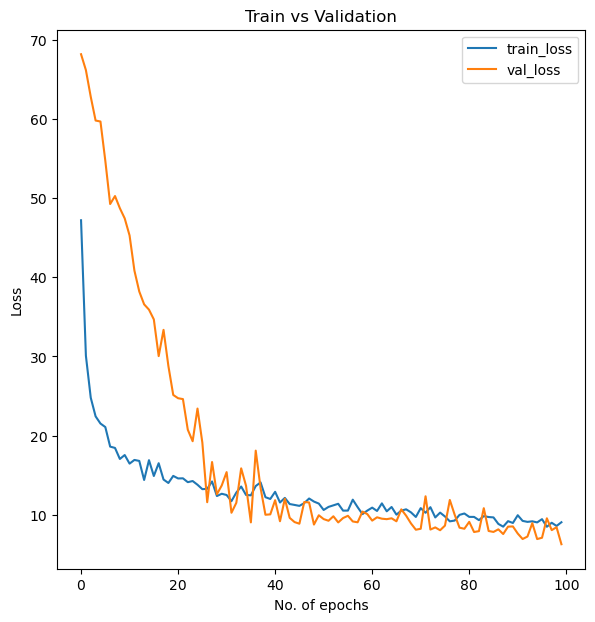

In [77]:
metrics_graph(cnnmodel, 100)

In [78]:
## Save the model
model.save(curr_dir + '/Models/Kodangal/CNNModel_cu.keras')
print('Saved sample model to disk')

Saved sample model to disk


In [21]:
model = load_model(curr_dir + '/Models/Kodangal/CNNModel_cu.keras')

In [22]:
image_path = curr_dir + '/Images'
plot_model(model, to_file=image_path + '/CNN_Kodangal_cu.png', show_shapes=True, show_layer_names=True, rankdir='LR')

img = plt.imread(image_path + '/CNN_Kodangal_cu.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [120]:
new_inp = np.expand_dims(X_test[0], axis=0)
new_inp.shape

(1, 52, 1)

In [25]:
def predict(model, X, y, n_bins):

    y_pred = model.predict(X).flatten()

    percentiles = np.linspace(0, 100, n_bins+1)
    bin_edges = np.percentile(y, percentiles)

    bin_labels = [f"{int(percentiles[i])}-{int(percentiles[i+1])}%" for i in range(len(percentiles) - 1)]

    bin_indices = np.digitize(y_pred, bin_edges, right=True)

    bin_indices = np.clip(bin_indices - 1, 0, len(bin_labels) - 1)

    pred_cat = [bin_labels[i] for i in bin_indices]

    return pred_cat, bin_edges, y_pred    

In [27]:
pred_catg, bins, y_pred = predict(model, X_test, y_train, 5)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [39]:
eval_model(y_test, y_pred, 'Test set')

Test set
Mean Absolute Error: 7.230000019073486


In [32]:
plot_vals = pd.DataFrame({
    'Identifier': y_test.index,
    'Actual': y_test,
    'Predicted': y_pred
})

plot_vals = plot_vals.sort_values(by='Identifier')

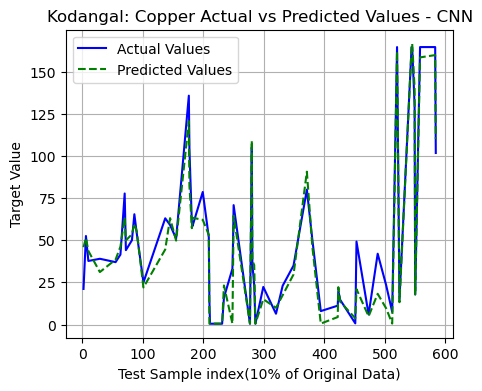

In [33]:
plt.figure(figsize=(5, 4))
plt.plot(plot_vals['Actual'], label='Actual Values', color='blue')
plt.plot(plot_vals['Predicted'], label='Predicted Values', color='green', linestyle='--')
plt.title('Kodangal: Copper Actual vs Predicted Values - CNN')
plt.xlabel('Test Sample index(10% of Original Data)')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.show()

In [141]:
bins

array([  0.5,  11.8,  30. ,  48.1,  93. , 164.5])

In [155]:
catg = list(set(pred_catg))
catg

['20-40%', '80-100%', '60-80%', '0-20%', '40-60%']

In [166]:
def extract_lower_bound(range_str):
    # Extract the first number using regular expressions
    return int(re.findall(r'\d+', range_str)[0])

catg = sorted(catg, key=extract_lower_bound)

bins_range = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

ppm_conc_cu = pd.DataFrame({
    'ppm' : bins_range,
    '% range' : catg
})
ppm_conc_cu

,ppm,% range
0,0.5-11.8,0-20%
1,11.8-30.0,20-40%
2,30.0-48.1,40-60%
3,48.1-93.0,60-80%
4,93.0-164.5,80-100%
